## Segmentation map으로 도로 이미지 만들기
Pix2Pix 논문에서 제시한 실험 중에 도로의 레이블 정보를 활용해 이미지를 생성해낸 실험이 있습니다.  
이번 프로젝트에선 해당 논문에서 사용한 데이터셋을 Pix2Pix를 학습시켜보겠습니다.

1. Data augementation을 부족한 데이터의 수 증가


2. Generator로 U-Net Generator 구조를 사용


3. 학습된 Generator와 테스트 이미지를 사용해 테스트를 진행해 보겠습니다. 


4. 3에서 Generator로 생성된 이미지를 segmentation map, Generator 생성 이미지, 실제 사진으로 시각화해서 잘되었는지 살펴 봅시다. 


5. 다양한 epoch 학습을 진행해 epoch가 이미지에 생성에 미치는 영향을 확인해 봅시다.

In [1]:
import os  # 데이터 로드
from tensorflow import data

# 데이터 코드 조작
import numpy as np 
import tensorflow as tf  

# 이미지 처리
import cv2    
import matplotlib.pyplot as plt

# data agumentation
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

print("데이터 준비 모듈 import")



from tensorflow.keras import layers, Input, Model

print("Generator, Discriminator 모듈 import")


데이터 준비 모듈 import
Generator, Discriminator 모듈 import


## 1. 데이터 준비
- 데이터 로드

- 불러온 이미지가 실제 이미지와, segmentation map이 붙어 있으므로 이 둘을 분리해서 사용합니다.

- Data augmentation 적용 :  
&nbsp; train 데이터가 1000개로 적은 수이기에 data augmentation을 통해 늘려주겠습니다. 

In [2]:
train_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

print("number of train examples :", len(os.listdir(train_path)))

number of train examples : 1000


논문에서 알 수 있듯이 train 데이터에는 1000개의 이미지가 있음을 확인할 수 있습니다.  

이제 train 이미지가 어떻게 생겼는지 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.

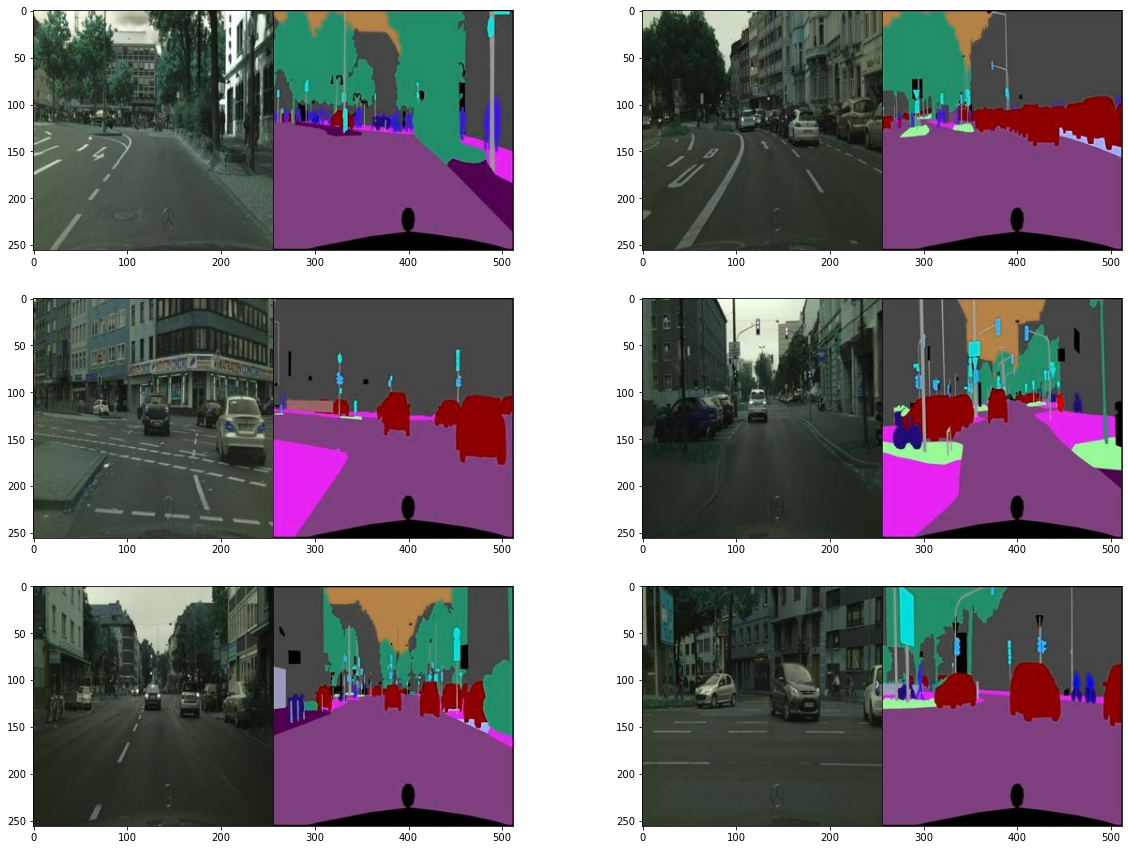

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_path + os.listdir(train_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

하나의 이미지에 도로 segmentation map과 실제 도로 이미지가 함께 포함되어 있음을 확인할 수 있습니다. 

이미지를 하나 열어 아래와 같이 크기를 확인해 보겠습니다.

In [4]:
f = train_path + os.listdir(train_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.

아래 코드로 이미지를 나누어 봅시다.

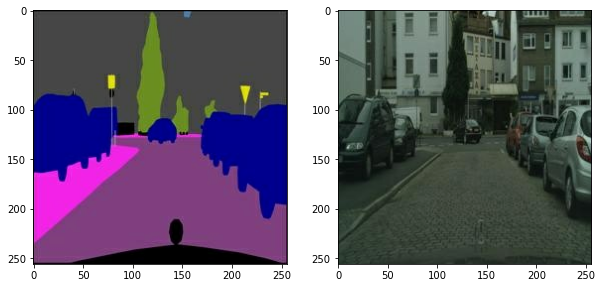

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    road = img[:, :w, :] 
    road = tf.cast(road, tf.float32)
    segment_map = img[:, w:, :] 
    segment_map = tf.cast(segment_map, tf.float32)
    return  normalize(segment_map), normalize(road)

f = train_path + os.listdir(train_path)[1]
segment_map , road  = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segment_map))
plt.subplot(1,2,2); plt.imshow(denormalize(road))

위와 같이 두 개 이미지로 나누었습니다. 첫 번째 segment_map를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 실제 이미지를 생성하는 것이 이번 단계의 목표입니다.  

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 1000개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(segment_map, road):
    stacked = tf.concat([segment_map, road], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    _pad2 = tf.constant([[52,52],[52,52],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    if tf.random.uniform(()) < .5:  # 50% 확률로 이미지 중앙을 기준으로 80% 확대
        padded = image.central_crop(padded, central_fraction=0.8)
        
        # (256, 256) 이미지 사이즈를 맞추기 위헤 PADDING 적용 
        # 256의 0.8이 204.8이므로 52의 패딩을 추가해 준다.

        padded = tf.pad(padded, _pad2, "CONSTANT", constant_values=1.) 
        
        
    out = image.random_crop(padded, size=[256, 256, 6])
    
    if tf.random.uniform(()) < .5:     # 50% 확률로 밝기 조절
        out = image.adjust_brightness(out, 0.35)
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

위와 같이 구성한 함수를 데이터에 적용해 시각화 해봅시다.

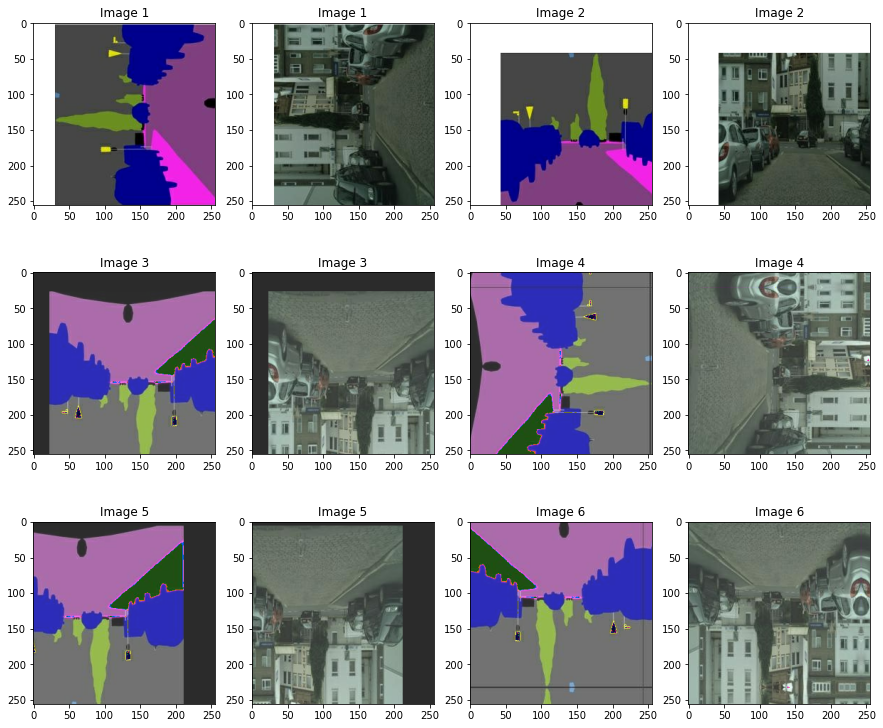

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_road = apply_augmentation(segment_map, road)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_road)); plt.title(f"Image {img_n}")
    img_n += 1

위의 보이는 것처럼 agumentation을 통해 매우 다양한 이미지가 생성됩니다. 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수도 있을것 같습니다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

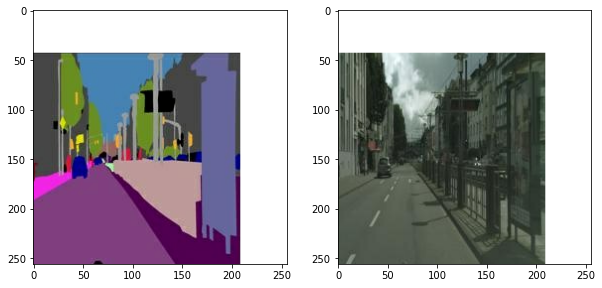

In [8]:
from tensorflow import data

def get_train(img_path):
    segment_map, road = load_img(img_path)
    segment_map, road = apply_augmentation(segment_map, road)
    return segment_map, road

train_images = data.Dataset.list_files(train_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment_map, road = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(segment_map[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(road[0].astype(np.uint8))

---

## 2. Generator 구성 [U-Net]

이제부터 본격적으로 Pix2Pix 구조를 구현합니다. Tensorflow의 Subclassing 방법을 이용해 모델을 만들겠습니다.  

Generator를 단순한 **Encoder-Decoder** 구조로 구성하는 것 보다 Encoder와 Decoder 사이를 skip connection으로 연결한 **U-Net** 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보입니다.  


**U-Net** 구조를 간단히 설명하면 Encoder에서 출력된 결과를 Decoder의 입력으로 연결한 기본 구조의 추가적으로 Encoder-Decoder을 skip connection으로 연결한 구조입니다.

먼저 Encoder 및 Decoder에 사용되는 기본적인 블록을 구현하겠습니다.

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

정의된 블록들을 이용해 한 번에 **U-Net Generator**를 정의해 보겠습니다. 아래 모델의 **__init__()** 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, **call()**에서 forward propagation 하도록 합니다. 

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


먼저, **__init__()** 에서 정의된 **encode_blocks** 및 **decode_blocks**가 **call()** 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행합니다.
이때, Encoder와 Decoder 사이의 skip connection을 위해 **features** 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았습니다.

이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, **features** 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용됩니다.

---

## 3. Discriminator 구성  

Generator만으로 좋은 결과를 도출하기에는 부족합니다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요합니다.
이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 보겠습니다.

Pix2Pix 논문에서의 Discriminator의 구조는 2개 입력("in", "unknown")을 받아 연결(CONCAT)한 후, **ENCODE** 블록 5개를 통과합니다.  
이 중 마지막 블록을 제외한 4개 블록은 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었습니다.  


최종적으로 출력되는 크기는 (30,30,1)가 되고 출력 크기가 (30, 30)이 되는 이유는 70x70 **PatchGAN**을 사용했기 때문입니다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정입니다.


> 논문에서 말하는 C64의 의미 :  
64개의 4x4 필터에 stride 2를 적용한 Convolution layer (0.2 slope의 LeakyReLU)

### Discriminator 구현하기
---
마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들겠습니다.


In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

**__init__()** 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(**n_filters**), 필터가 순회하는 간격(**stride**), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(**custom_pad**), BatchNorm의 사용 여부(**use_bn**), 활성화 함수 사용 여부(**act**)가 설정 가능합니다.

간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 봅시다.  
- (32,32) 에서 (31, 31) -> (30, 30)으로 갈 수 있는지 테스트해 봅시다.

In [12]:
inputs = Input((32,32,128))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(256, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

out = layers.ZeroPadding2D()(out)
out = layers.Conv2D(512, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

out = layers.Dense(1, activation=None)(out)

Model(inputs, out).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 128)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 31, 31, 256)       524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 256)       1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 31, 31, 256)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 512)       209715

이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시켜서 (30, 30)의 크기로 만들 수 있습니다.  

사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

**__init__()** 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다.  

첫 번째 블록은 단순한 연결(**concat**)을 수행하며, Discriminator의 최종 출력은 **sigmoid** 활성화를 사용했습니다.

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]          

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만드는데 성공했습니다.  

시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보겠습니다.

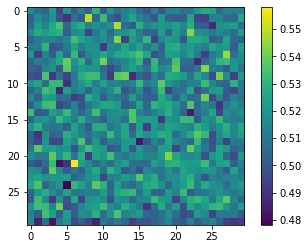

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---

## 4. 학습 및 테스트하기 

Generator와 Discriminator를 학습시켜보고, segment를 입력받아 도로 이미지를 생성해 봅시다.  
일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 낼수 있습니다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 봅시다.

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- Generator의 손실함수 (위 코드의 **get_gene_loss**)는 총 3개의 입력이 있습니다. 이 중 **fake_disc**는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 **tf.ones_like()**를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(**fake_output**)와 실제 이미지(**real_output**) 사이의 MAE(Mean Absolute Error)를 계산합니다.


- Discriminator의 손실함수 (위 코드의 **get_disc_loss**)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 **real_disc**는 "1"로 채워진 벡터와 비교하고, **fake_disc**는 "0"으로 채워진 벡터와 비교합니다.

optimizer는 논문과 동일하게 아래와 같이 설정합니다.

In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했습니다.

In [18]:
@tf.function
def train_step(segment_map, real_road):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_road = generator(segment_map, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment_map, fake_road, training=True)
        real_disc = discriminator(segment_map, real_road, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_road, real_road, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

앞서 정의한 함수를 이용해서 학습을 진행합니다.

In [19]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment_map, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment_map, road)

        # 20회 반복(iter)마다 손실을 출력합니다.
        if (i+1) % 20 == 0:  
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[20]                     
Generator_loss:0.8607                     
L1_loss:0.2339                     
Discriminator_loss:1.4566

EPOCH[1] - STEP[40]                     
Generator_loss:0.7169                     
L1_loss:0.2605                     
Discriminator_loss:1.3720

EPOCH[1] - STEP[60]                     
Generator_loss:0.9465                     
L1_loss:0.2167                     
Discriminator_loss:1.2111

EPOCH[1] - STEP[80]                     
Generator_loss:1.1071                     
L1_loss:0.2355                     
Discriminator_loss:1.0831

EPOCH[1] - STEP[100]                     
Generator_loss:0.9081                     
L1_loss:0.2085                     
Discriminator_loss:1.1871

EPOCH[1] - STEP[120]                     
Generator_loss:1.4486                     
L1_loss:0.1924                     
Discriminator_loss:1.2626

EPOCH[1] - STEP[140]                     
Generator_loss:0.8171                     
L1_loss:0.1998                 

EPOCH[5] - STEP[180]                     
Generator_loss:1.4185                     
L1_loss:0.1803                     
Discriminator_loss:0.6441

EPOCH[5] - STEP[200]                     
Generator_loss:1.3277                     
L1_loss:0.2036                     
Discriminator_loss:0.6650

EPOCH[5] - STEP[220]                     
Generator_loss:3.6771                     
L1_loss:0.1852                     
Discriminator_loss:2.0748

EPOCH[5] - STEP[240]                     
Generator_loss:1.6488                     
L1_loss:0.1823                     
Discriminator_loss:1.0904

EPOCH[6] - STEP[20]                     
Generator_loss:1.6161                     
L1_loss:0.1642                     
Discriminator_loss:0.9514

EPOCH[6] - STEP[40]                     
Generator_loss:0.3453                     
L1_loss:0.2172                     
Discriminator_loss:1.9787

EPOCH[6] - STEP[60]                     
Generator_loss:2.5827                     
L1_loss:0.1857                

EPOCH[10] - STEP[100]                     
Generator_loss:2.9783                     
L1_loss:0.1896                     
Discriminator_loss:0.3746

EPOCH[10] - STEP[120]                     
Generator_loss:1.3688                     
L1_loss:0.1876                     
Discriminator_loss:0.7812

EPOCH[10] - STEP[140]                     
Generator_loss:2.1294                     
L1_loss:0.2045                     
Discriminator_loss:0.7305

EPOCH[10] - STEP[160]                     
Generator_loss:0.3202                     
L1_loss:0.1749                     
Discriminator_loss:1.7979

EPOCH[10] - STEP[180]                     
Generator_loss:2.7894                     
L1_loss:0.1540                     
Discriminator_loss:1.2018

EPOCH[10] - STEP[200]                     
Generator_loss:0.8125                     
L1_loss:0.1600                     
Discriminator_loss:1.2937

EPOCH[10] - STEP[220]                     
Generator_loss:2.5319                     
L1_loss:0.1760      

아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜봅시다.  
테스트는 이미지는 val image로 확인해보겠습니다.

In [30]:
val_path

'/home/ssac27/aiffel/conditional_generation/cityscapes/val/'

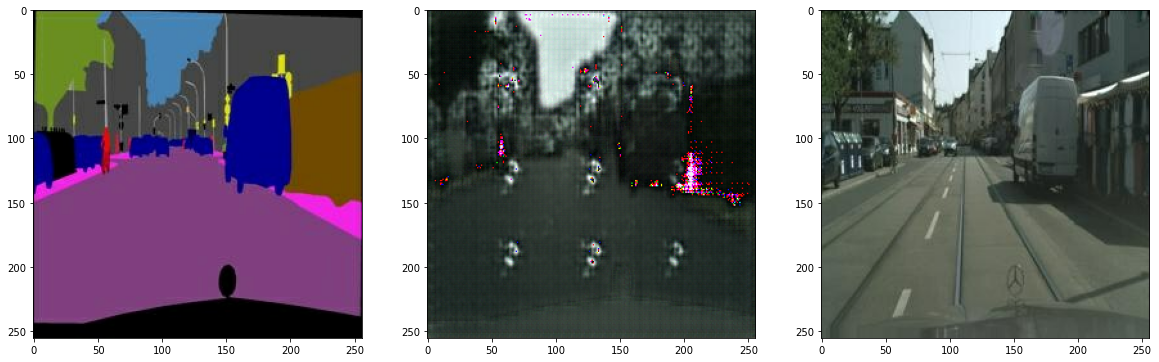

In [31]:
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
segment_map,road = load_img(f)

pred = generator(tf.expand_dims(segment_map, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment_map))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(road))


#### epoch 10 
결과를 보면 오른쪽의 이미지와 흡사한 모습이 보이긴 하지만, 전체적으로 noise가 심한 모습이 보입니다.   

반복횟수를 10 -> 50으로 증가해서 결과를 다시 확인 해보겠습니다.

#### epoch 50

In [19]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment_map, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment_map, road)

        # 20회 반복(iter)마다 손실을 출력합니다.
        if (i+1) % 20 == 0:  
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[20]                     
Generator_loss:0.7698                     
L1_loss:0.1779                     
Discriminator_loss:1.3471

EPOCH[1] - STEP[40]                     
Generator_loss:0.7332                     
L1_loss:0.2205                     
Discriminator_loss:1.3341

EPOCH[1] - STEP[60]                     
Generator_loss:1.0177                     
L1_loss:0.1739                     
Discriminator_loss:1.3167

EPOCH[1] - STEP[80]                     
Generator_loss:0.9638                     
L1_loss:0.2204                     
Discriminator_loss:1.3202

EPOCH[1] - STEP[100]                     
Generator_loss:1.3778                     
L1_loss:0.2251                     
Discriminator_loss:0.8427

EPOCH[1] - STEP[120]                     
Generator_loss:1.0060                     
L1_loss:0.2406                     
Discriminator_loss:1.1190

EPOCH[1] - STEP[140]                     
Generator_loss:1.2313                     
L1_loss:0.1776                 

EPOCH[5] - STEP[180]                     
Generator_loss:2.0647                     
L1_loss:0.1828                     
Discriminator_loss:0.5440

EPOCH[5] - STEP[200]                     
Generator_loss:1.5285                     
L1_loss:0.1694                     
Discriminator_loss:0.6645

EPOCH[5] - STEP[220]                     
Generator_loss:2.9120                     
L1_loss:0.1699                     
Discriminator_loss:0.9254

EPOCH[5] - STEP[240]                     
Generator_loss:0.9333                     
L1_loss:0.1906                     
Discriminator_loss:0.8108

EPOCH[6] - STEP[20]                     
Generator_loss:1.7079                     
L1_loss:0.1506                     
Discriminator_loss:0.5889

EPOCH[6] - STEP[40]                     
Generator_loss:2.3626                     
L1_loss:0.1690                     
Discriminator_loss:1.6760

EPOCH[6] - STEP[60]                     
Generator_loss:2.5730                     
L1_loss:0.2003                

EPOCH[10] - STEP[100]                     
Generator_loss:1.4750                     
L1_loss:0.1589                     
Discriminator_loss:0.8836

EPOCH[10] - STEP[120]                     
Generator_loss:2.0879                     
L1_loss:0.1732                     
Discriminator_loss:1.0963

EPOCH[10] - STEP[140]                     
Generator_loss:1.3596                     
L1_loss:0.1594                     
Discriminator_loss:0.9404

EPOCH[10] - STEP[160]                     
Generator_loss:2.0384                     
L1_loss:0.2208                     
Discriminator_loss:0.2929

EPOCH[10] - STEP[180]                     
Generator_loss:0.7076                     
L1_loss:0.1867                     
Discriminator_loss:0.8568

EPOCH[10] - STEP[200]                     
Generator_loss:0.8284                     
L1_loss:0.1922                     
Discriminator_loss:0.6924

EPOCH[10] - STEP[220]                     
Generator_loss:3.0612                     
L1_loss:0.2001      

EPOCH[15] - STEP[20]                     
Generator_loss:1.1260                     
L1_loss:0.2068                     
Discriminator_loss:0.7331

EPOCH[15] - STEP[40]                     
Generator_loss:1.5106                     
L1_loss:0.1579                     
Discriminator_loss:0.4904

EPOCH[15] - STEP[60]                     
Generator_loss:1.5545                     
L1_loss:0.1588                     
Discriminator_loss:0.4237

EPOCH[15] - STEP[80]                     
Generator_loss:0.8455                     
L1_loss:0.1860                     
Discriminator_loss:0.8267

EPOCH[15] - STEP[100]                     
Generator_loss:2.0706                     
L1_loss:0.1463                     
Discriminator_loss:1.5985

EPOCH[15] - STEP[120]                     
Generator_loss:2.0530                     
L1_loss:0.1717                     
Discriminator_loss:0.4907

EPOCH[15] - STEP[140]                     
Generator_loss:2.0876                     
L1_loss:0.1809          

EPOCH[19] - STEP[180]                     
Generator_loss:1.9826                     
L1_loss:0.1727                     
Discriminator_loss:0.9382

EPOCH[19] - STEP[200]                     
Generator_loss:0.3052                     
L1_loss:0.1565                     
Discriminator_loss:1.8821

EPOCH[19] - STEP[220]                     
Generator_loss:1.4898                     
L1_loss:0.1555                     
Discriminator_loss:1.8108

EPOCH[19] - STEP[240]                     
Generator_loss:1.8331                     
L1_loss:0.2014                     
Discriminator_loss:0.3008

EPOCH[20] - STEP[20]                     
Generator_loss:1.2504                     
L1_loss:0.1648                     
Discriminator_loss:1.4649

EPOCH[20] - STEP[40]                     
Generator_loss:0.1489                     
L1_loss:0.1617                     
Discriminator_loss:2.2951

EPOCH[20] - STEP[60]                     
Generator_loss:1.9085                     
L1_loss:0.1639         

EPOCH[24] - STEP[100]                     
Generator_loss:0.9445                     
L1_loss:0.1564                     
Discriminator_loss:1.2667

EPOCH[24] - STEP[120]                     
Generator_loss:0.4100                     
L1_loss:0.1882                     
Discriminator_loss:1.5735

EPOCH[24] - STEP[140]                     
Generator_loss:1.8753                     
L1_loss:0.1689                     
Discriminator_loss:0.2937

EPOCH[24] - STEP[160]                     
Generator_loss:1.4436                     
L1_loss:0.1599                     
Discriminator_loss:1.7521

EPOCH[24] - STEP[180]                     
Generator_loss:1.2593                     
L1_loss:0.1815                     
Discriminator_loss:0.4662

EPOCH[24] - STEP[200]                     
Generator_loss:0.3970                     
L1_loss:0.1741                     
Discriminator_loss:1.2720

EPOCH[24] - STEP[220]                     
Generator_loss:0.7000                     
L1_loss:0.1723      

EPOCH[29] - STEP[20]                     
Generator_loss:0.3518                     
L1_loss:0.1680                     
Discriminator_loss:1.7021

EPOCH[29] - STEP[40]                     
Generator_loss:2.0996                     
L1_loss:0.1691                     
Discriminator_loss:0.4879

EPOCH[29] - STEP[60]                     
Generator_loss:1.7150                     
L1_loss:0.1835                     
Discriminator_loss:0.3246

EPOCH[29] - STEP[80]                     
Generator_loss:1.2228                     
L1_loss:0.1817                     
Discriminator_loss:1.3161

EPOCH[29] - STEP[100]                     
Generator_loss:1.6861                     
L1_loss:0.1699                     
Discriminator_loss:0.4001

EPOCH[29] - STEP[120]                     
Generator_loss:1.6326                     
L1_loss:0.1603                     
Discriminator_loss:0.6783

EPOCH[29] - STEP[140]                     
Generator_loss:1.6070                     
L1_loss:0.1825          

EPOCH[33] - STEP[180]                     
Generator_loss:1.2537                     
L1_loss:0.2068                     
Discriminator_loss:0.4579

EPOCH[33] - STEP[200]                     
Generator_loss:0.9857                     
L1_loss:0.1476                     
Discriminator_loss:0.9932

EPOCH[33] - STEP[220]                     
Generator_loss:1.4938                     
L1_loss:0.1802                     
Discriminator_loss:0.6448

EPOCH[33] - STEP[240]                     
Generator_loss:1.2532                     
L1_loss:0.1415                     
Discriminator_loss:2.1958

EPOCH[34] - STEP[20]                     
Generator_loss:0.8990                     
L1_loss:0.1703                     
Discriminator_loss:0.8135

EPOCH[34] - STEP[40]                     
Generator_loss:0.6756                     
L1_loss:0.1488                     
Discriminator_loss:1.1108

EPOCH[34] - STEP[60]                     
Generator_loss:2.9366                     
L1_loss:0.1625         

EPOCH[38] - STEP[100]                     
Generator_loss:2.2448                     
L1_loss:0.1819                     
Discriminator_loss:0.8376

EPOCH[38] - STEP[120]                     
Generator_loss:1.9357                     
L1_loss:0.1695                     
Discriminator_loss:1.8757

EPOCH[38] - STEP[140]                     
Generator_loss:2.0750                     
L1_loss:0.1590                     
Discriminator_loss:1.0127

EPOCH[38] - STEP[160]                     
Generator_loss:1.2819                     
L1_loss:0.1672                     
Discriminator_loss:0.7038

EPOCH[38] - STEP[180]                     
Generator_loss:2.2568                     
L1_loss:0.1700                     
Discriminator_loss:0.2964

EPOCH[38] - STEP[200]                     
Generator_loss:1.0212                     
L1_loss:0.1290                     
Discriminator_loss:1.9469

EPOCH[38] - STEP[220]                     
Generator_loss:1.5250                     
L1_loss:0.1834      

EPOCH[43] - STEP[20]                     
Generator_loss:2.5981                     
L1_loss:0.1471                     
Discriminator_loss:1.2111

EPOCH[43] - STEP[40]                     
Generator_loss:1.7643                     
L1_loss:0.1616                     
Discriminator_loss:0.5342

EPOCH[43] - STEP[60]                     
Generator_loss:2.2610                     
L1_loss:0.1738                     
Discriminator_loss:1.0458

EPOCH[43] - STEP[80]                     
Generator_loss:1.7068                     
L1_loss:0.1574                     
Discriminator_loss:0.6942

EPOCH[43] - STEP[100]                     
Generator_loss:1.0623                     
L1_loss:0.1660                     
Discriminator_loss:0.6855

EPOCH[43] - STEP[120]                     
Generator_loss:0.5360                     
L1_loss:0.1715                     
Discriminator_loss:1.1309

EPOCH[43] - STEP[140]                     
Generator_loss:1.5003                     
L1_loss:0.1580          

EPOCH[47] - STEP[180]                     
Generator_loss:0.6462                     
L1_loss:0.1449                     
Discriminator_loss:1.0988

EPOCH[47] - STEP[200]                     
Generator_loss:0.8223                     
L1_loss:0.1637                     
Discriminator_loss:0.9281

EPOCH[47] - STEP[220]                     
Generator_loss:1.1634                     
L1_loss:0.1416                     
Discriminator_loss:1.3217

EPOCH[47] - STEP[240]                     
Generator_loss:1.2586                     
L1_loss:0.1483                     
Discriminator_loss:1.5896

EPOCH[48] - STEP[20]                     
Generator_loss:0.8672                     
L1_loss:0.1895                     
Discriminator_loss:0.6977

EPOCH[48] - STEP[40]                     
Generator_loss:1.2500                     
L1_loss:0.1716                     
Discriminator_loss:0.5828

EPOCH[48] - STEP[60]                     
Generator_loss:0.4382                     
L1_loss:0.1664         

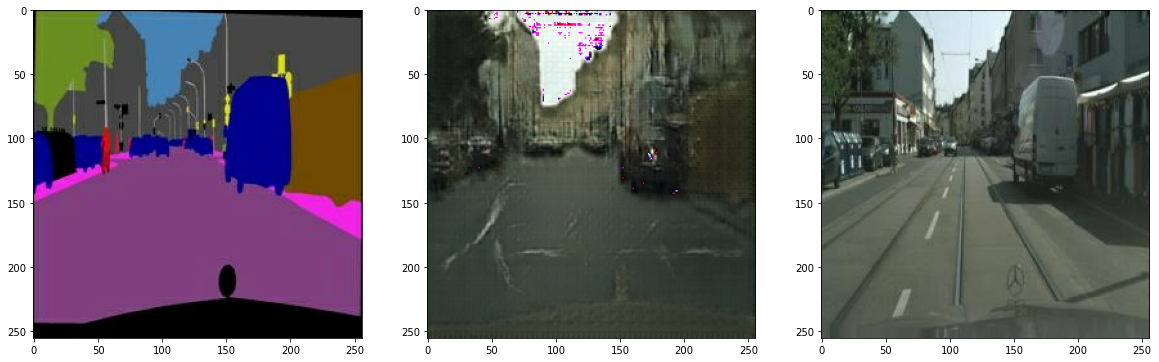

In [20]:
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
segment_map,road = load_img(f)

pred = generator(tf.expand_dims(segment_map, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment_map))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(road))

#### epoch 50 
결과를 보면 epoch 10번 했을떄의 결과보다 더 실제 도로의 모습과 흡사해 졌습니다.  
이것으로 epoch를 증가함에따라 더 좋은 결과가 나오는것을 확인할 수 있게 되었네요.

반복횟수를 50 -> 120으로 증가해서 결과를 다시 확인 해보겠습니다.

#### epoch 120

In [19]:
EPOCHS = 120

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment_map, road) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment_map, road)

        # 20회 반복(iter)마다 손실을 출력합니다.
        if (i+1) % 40 == 0:  
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[40]                     
Generator_loss:0.7609                     
L1_loss:0.2327                     
Discriminator_loss:1.3827

EPOCH[1] - STEP[80]                     
Generator_loss:1.2548                     
L1_loss:0.1661                     
Discriminator_loss:1.1857

EPOCH[1] - STEP[120]                     
Generator_loss:1.1202                     
L1_loss:0.2247                     
Discriminator_loss:0.8726

EPOCH[1] - STEP[160]                     
Generator_loss:1.4678                     
L1_loss:0.1812                     
Discriminator_loss:1.4110

EPOCH[1] - STEP[200]                     
Generator_loss:1.5869                     
L1_loss:0.2298                     
Discriminator_loss:1.0314

EPOCH[1] - STEP[240]                     
Generator_loss:1.8609                     
L1_loss:0.1738                     
Discriminator_loss:1.3135

EPOCH[2] - STEP[40]                     
Generator_loss:2.4778                     
L1_loss:0.1818                

EPOCH[10] - STEP[120]                     
Generator_loss:0.8469                     
L1_loss:0.1609                     
Discriminator_loss:1.7491

EPOCH[10] - STEP[160]                     
Generator_loss:0.9330                     
L1_loss:0.1762                     
Discriminator_loss:0.9355

EPOCH[10] - STEP[200]                     
Generator_loss:1.6770                     
L1_loss:0.1781                     
Discriminator_loss:0.4174

EPOCH[10] - STEP[240]                     
Generator_loss:1.5804                     
L1_loss:0.1862                     
Discriminator_loss:0.4901

EPOCH[11] - STEP[40]                     
Generator_loss:2.3570                     
L1_loss:0.1822                     
Discriminator_loss:0.4157

EPOCH[11] - STEP[80]                     
Generator_loss:2.5984                     
L1_loss:0.1593                     
Discriminator_loss:0.8838

EPOCH[11] - STEP[120]                     
Generator_loss:2.4488                     
L1_loss:0.2045        

EPOCH[19] - STEP[200]                     
Generator_loss:2.6430                     
L1_loss:0.1974                     
Discriminator_loss:0.3452

EPOCH[19] - STEP[240]                     
Generator_loss:0.3205                     
L1_loss:0.1680                     
Discriminator_loss:1.4868

EPOCH[20] - STEP[40]                     
Generator_loss:1.0682                     
L1_loss:0.1876                     
Discriminator_loss:0.6381

EPOCH[20] - STEP[80]                     
Generator_loss:0.9429                     
L1_loss:0.1493                     
Discriminator_loss:0.6879

EPOCH[20] - STEP[120]                     
Generator_loss:0.5371                     
L1_loss:0.2110                     
Discriminator_loss:1.1143

EPOCH[20] - STEP[160]                     
Generator_loss:1.1054                     
L1_loss:0.1666                     
Discriminator_loss:0.8351

EPOCH[20] - STEP[200]                     
Generator_loss:0.9306                     
L1_loss:0.1417        

EPOCH[29] - STEP[40]                     
Generator_loss:1.0939                     
L1_loss:0.1635                     
Discriminator_loss:0.7757

EPOCH[29] - STEP[80]                     
Generator_loss:0.9752                     
L1_loss:0.1595                     
Discriminator_loss:1.0512

EPOCH[29] - STEP[120]                     
Generator_loss:1.7199                     
L1_loss:0.1609                     
Discriminator_loss:0.8561

EPOCH[29] - STEP[160]                     
Generator_loss:1.2871                     
L1_loss:0.2102                     
Discriminator_loss:0.4093

EPOCH[29] - STEP[200]                     
Generator_loss:0.7709                     
L1_loss:0.1399                     
Discriminator_loss:1.5076

EPOCH[29] - STEP[240]                     
Generator_loss:1.7266                     
L1_loss:0.1448                     
Discriminator_loss:1.7414

EPOCH[30] - STEP[40]                     
Generator_loss:0.3791                     
L1_loss:0.1737         

EPOCH[38] - STEP[120]                     
Generator_loss:0.9560                     
L1_loss:0.1630                     
Discriminator_loss:0.7597

EPOCH[38] - STEP[160]                     
Generator_loss:2.3143                     
L1_loss:0.1769                     
Discriminator_loss:0.9911

EPOCH[38] - STEP[200]                     
Generator_loss:1.0160                     
L1_loss:0.1581                     
Discriminator_loss:1.1594

EPOCH[38] - STEP[240]                     
Generator_loss:2.3879                     
L1_loss:0.1422                     
Discriminator_loss:1.5130

EPOCH[39] - STEP[40]                     
Generator_loss:1.8335                     
L1_loss:0.1618                     
Discriminator_loss:0.6972

EPOCH[39] - STEP[80]                     
Generator_loss:1.8009                     
L1_loss:0.1714                     
Discriminator_loss:1.0743

EPOCH[39] - STEP[120]                     
Generator_loss:1.1437                     
L1_loss:0.1545        

EPOCH[47] - STEP[200]                     
Generator_loss:0.9696                     
L1_loss:0.1877                     
Discriminator_loss:0.8050

EPOCH[47] - STEP[240]                     
Generator_loss:1.6068                     
L1_loss:0.1720                     
Discriminator_loss:0.6809

EPOCH[48] - STEP[40]                     
Generator_loss:2.7107                     
L1_loss:0.1470                     
Discriminator_loss:1.5545

EPOCH[48] - STEP[80]                     
Generator_loss:1.3433                     
L1_loss:0.2005                     
Discriminator_loss:0.4000

EPOCH[48] - STEP[120]                     
Generator_loss:1.8834                     
L1_loss:0.1625                     
Discriminator_loss:0.4626

EPOCH[48] - STEP[160]                     
Generator_loss:2.3058                     
L1_loss:0.1701                     
Discriminator_loss:0.6015

EPOCH[48] - STEP[200]                     
Generator_loss:2.3930                     
L1_loss:0.1892        

EPOCH[57] - STEP[40]                     
Generator_loss:0.6445                     
L1_loss:0.1731                     
Discriminator_loss:1.0062

EPOCH[57] - STEP[80]                     
Generator_loss:2.7817                     
L1_loss:0.1802                     
Discriminator_loss:0.2699

EPOCH[57] - STEP[120]                     
Generator_loss:1.3393                     
L1_loss:0.1259                     
Discriminator_loss:1.5068

EPOCH[57] - STEP[160]                     
Generator_loss:0.7431                     
L1_loss:0.1417                     
Discriminator_loss:1.3260

EPOCH[57] - STEP[200]                     
Generator_loss:1.0405                     
L1_loss:0.1245                     
Discriminator_loss:1.4894

EPOCH[57] - STEP[240]                     
Generator_loss:0.4911                     
L1_loss:0.1565                     
Discriminator_loss:1.1604

EPOCH[58] - STEP[40]                     
Generator_loss:1.3430                     
L1_loss:0.1676         

EPOCH[66] - STEP[120]                     
Generator_loss:0.5365                     
L1_loss:0.1371                     
Discriminator_loss:1.2215

EPOCH[66] - STEP[160]                     
Generator_loss:1.8642                     
L1_loss:0.2053                     
Discriminator_loss:0.2568

EPOCH[66] - STEP[200]                     
Generator_loss:0.9714                     
L1_loss:0.1767                     
Discriminator_loss:0.9461

EPOCH[66] - STEP[240]                     
Generator_loss:1.4179                     
L1_loss:0.1441                     
Discriminator_loss:0.5995

EPOCH[67] - STEP[40]                     
Generator_loss:1.2368                     
L1_loss:0.1839                     
Discriminator_loss:0.7432

EPOCH[67] - STEP[80]                     
Generator_loss:1.5933                     
L1_loss:0.1810                     
Discriminator_loss:0.4105

EPOCH[67] - STEP[120]                     
Generator_loss:2.2876                     
L1_loss:0.1858        

EPOCH[75] - STEP[200]                     
Generator_loss:0.6672                     
L1_loss:0.1497                     
Discriminator_loss:0.9070

EPOCH[75] - STEP[240]                     
Generator_loss:2.4246                     
L1_loss:0.1745                     
Discriminator_loss:0.3663

EPOCH[76] - STEP[40]                     
Generator_loss:1.4786                     
L1_loss:0.1663                     
Discriminator_loss:0.4078

EPOCH[76] - STEP[80]                     
Generator_loss:0.4695                     
L1_loss:0.1519                     
Discriminator_loss:1.2198

EPOCH[76] - STEP[120]                     
Generator_loss:0.5382                     
L1_loss:0.1629                     
Discriminator_loss:1.4398

EPOCH[76] - STEP[160]                     
Generator_loss:1.7447                     
L1_loss:0.1404                     
Discriminator_loss:0.8581

EPOCH[76] - STEP[200]                     
Generator_loss:2.1506                     
L1_loss:0.1523        

EPOCH[85] - STEP[40]                     
Generator_loss:0.2620                     
L1_loss:0.1743                     
Discriminator_loss:1.6938

EPOCH[85] - STEP[80]                     
Generator_loss:0.3781                     
L1_loss:0.1686                     
Discriminator_loss:1.5451

EPOCH[85] - STEP[120]                     
Generator_loss:2.5653                     
L1_loss:0.1657                     
Discriminator_loss:0.6739

EPOCH[85] - STEP[160]                     
Generator_loss:2.3482                     
L1_loss:0.1704                     
Discriminator_loss:1.7429

EPOCH[85] - STEP[200]                     
Generator_loss:0.7592                     
L1_loss:0.1402                     
Discriminator_loss:1.3924

EPOCH[85] - STEP[240]                     
Generator_loss:1.5086                     
L1_loss:0.1580                     
Discriminator_loss:0.6934

EPOCH[86] - STEP[40]                     
Generator_loss:1.1332                     
L1_loss:0.2196         

EPOCH[94] - STEP[120]                     
Generator_loss:1.3389                     
L1_loss:0.1554                     
Discriminator_loss:0.8635

EPOCH[94] - STEP[160]                     
Generator_loss:2.1365                     
L1_loss:0.2022                     
Discriminator_loss:0.2017

EPOCH[94] - STEP[200]                     
Generator_loss:1.3810                     
L1_loss:0.1871                     
Discriminator_loss:0.8236

EPOCH[94] - STEP[240]                     
Generator_loss:1.2970                     
L1_loss:0.1679                     
Discriminator_loss:0.3810

EPOCH[95] - STEP[40]                     
Generator_loss:0.8051                     
L1_loss:0.1573                     
Discriminator_loss:1.2893

EPOCH[95] - STEP[80]                     
Generator_loss:0.6594                     
L1_loss:0.1550                     
Discriminator_loss:2.1468

EPOCH[95] - STEP[120]                     
Generator_loss:2.0893                     
L1_loss:0.1495        

EPOCH[103] - STEP[160]                     
Generator_loss:2.2428                     
L1_loss:0.1819                     
Discriminator_loss:0.4045

EPOCH[103] - STEP[200]                     
Generator_loss:1.0097                     
L1_loss:0.1463                     
Discriminator_loss:1.4211

EPOCH[103] - STEP[240]                     
Generator_loss:1.4852                     
L1_loss:0.1593                     
Discriminator_loss:1.7240

EPOCH[104] - STEP[40]                     
Generator_loss:2.4785                     
L1_loss:0.1417                     
Discriminator_loss:0.5816

EPOCH[104] - STEP[80]                     
Generator_loss:1.7145                     
L1_loss:0.2010                     
Discriminator_loss:0.3722

EPOCH[104] - STEP[120]                     
Generator_loss:2.6070                     
L1_loss:0.1187                     
Discriminator_loss:2.8067

EPOCH[104] - STEP[160]                     
Generator_loss:1.0372                     
L1_loss:0.1697 

EPOCH[112] - STEP[200]                     
Generator_loss:1.9606                     
L1_loss:0.1797                     
Discriminator_loss:0.2669

EPOCH[112] - STEP[240]                     
Generator_loss:1.6189                     
L1_loss:0.1603                     
Discriminator_loss:0.5184

EPOCH[113] - STEP[40]                     
Generator_loss:1.2736                     
L1_loss:0.1564                     
Discriminator_loss:1.3073

EPOCH[113] - STEP[80]                     
Generator_loss:0.5507                     
L1_loss:0.1923                     
Discriminator_loss:1.0324

EPOCH[113] - STEP[120]                     
Generator_loss:1.5972                     
L1_loss:0.1766                     
Discriminator_loss:0.7107

EPOCH[113] - STEP[160]                     
Generator_loss:0.6821                     
L1_loss:0.1542                     
Discriminator_loss:1.1996

EPOCH[113] - STEP[200]                     
Generator_loss:0.9343                     
L1_loss:0.1441 

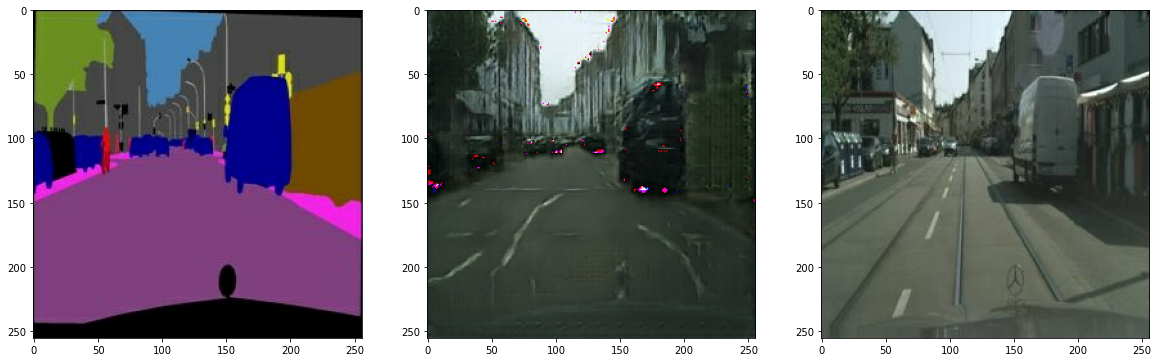

In [20]:
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
segment_map,road = load_img(f)

pred = generator(tf.expand_dims(segment_map, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment_map))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(road))

epoch를 120번 돌리자 도로의 형태도 보이고 자동차의 형태도 제대로 보이네요.   

결과물을 보면 위에서부터 10번 -> 50번 -> 120번 순으로 cGAN의 결과가 좋아지는 것을 확인할 수 있습니다.  

---

##  회고

- 예전에 했었던 GAN 프로젝트때는 며칠 동안 제대로 된 결과물이 나오기까지 계속해서 네트워크 구조를 조정하고 Hyper parameter들을 여러번 비교하면서 더 좋은 값으로 바꾸는 작업을 했었는데 이번 cGAN의 경우 많은 네트워크 구조의 조정이나 Hyper parameter 값의 변경이 적었음에도 결과물이 금방 그럴듯하게 나왔습니다.<br><br>  
가장 큰 이유로는 저번에 했었던 GAN의 경우 (32,32)에 작은 사이즈 이미지여서 더 결과물이 제대로 안나왔던것 같습니다.  


- 이번 cGAN의 경우 결과가 좋게 나와서 GAN 했을때 보다 재미있게 프로젝트를 진행한것 같습니다.  그리고 일반 GAN에서는 안되었던 원하는 이미지를 새로 생성하는 부분으로 할 수 있는 프로젝트가 많은것 같아서 그런 프로젝트를 생각하면서 진행하니 더 좋은 결과가 나왔던것 같네요. 


- 예를들어, 특정 이미지를 진짜 같이 생성할 수 있으면 위조된 그림을 판별할 때 학습시킬 데이터를 만들 모델로 사용할 수도 있겠네요.  
GAN에 대해서 알면 알수록 많은 분야에서 효율적으로 사용할 수 있는 기술인 것 같습니다. <br>   제가 생각하는 GAN 기술은 앞으로 AI를 활용한 이미지 분야에서 안 좋은 용도로 사용된 시각적 결과를 판별할 수 있는 필수적인 기술인것 같습니다. 